Sebastian Raschka, 2015

# Python Machine Learning Essentials

# Chapter 11 - Working with Unlabeled Data – Clustering Analysis

Note that the optional watermark extension is a small IPython notebook plugin that I developed to make the code reproducible. You can just skip the following line(s).

In [2]:
%load_ext watermark
#%watermark -a 'Sebastian Raschka' -u -d -v -p numpy,pandas,matplotlib,scipy,scikit-learn
%watermark -u -d -v -p numpy,pandas,matplotlib,scipy,scikit-learn

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
Last updated: 2022-09-24

Python implementation: CPython
Python version       : 3.8.8
IPython version      : 8.3.0

numpy       : 1.19.0
pandas      : 1.4.1
matplotlib  : 3.5.1
scipy       : 1.4.1
scikit-learn: 1.0.2



In [ ]:
# to install watermark just uncomment the following line:
#%install_ext https://raw.githubusercontent.com/rasbt/watermark/master/watermark.py

<br>
<br>

# Sections

- [Grouping objects by similarity using k-means](#Grouping-objects-by-similarity-using-K-means)
    - [Using the elbow method to find the optimal number of clusters](#Using-the-elbow-method-to-find-the-optimal-number-of-clusters)
    - [Quantifying the quality of clustering via silhouette plots](#Quantifying-the-quality-of-clustering)
- [Organizing clusters as a hierarchical tree](#Organizing-clusters-as-a-hierarchical-tree)
    - [Performing hierarchical clustering on a distance matrix](#Performing-hierarchical-clustering-on-a-distance-matrix)
    - [Attaching dendrograms to a heat map](#Attaching-dendrograms-to-a-heat-map)
    - [Applying agglomerative clustering via scikit-learn](#Applying-agglomerative-clustering-via-scikit-learn)
- [Locating regions of high density via DBSCAN](#Locating-regions-of-high-density-via-DBSCAN)

<br>
<br>

# Grouping objects by similarity using k-means

[[back to top](#Sections)]

In [1]:
from sklearn.datasets import make_blobs
X, y = make_blobs(n_samples=150, 
                  n_features=2, 
                  centers=3, 
                  cluster_std=0.5, 
                  shuffle=True, 
                  random_state=0)
#X

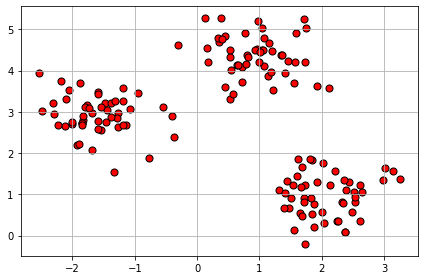

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.scatter(X[:,0], X[:,1],  c='red', marker='o', edgecolor='black',s=50)
#plt.scatter(X[:,0], X[:,1],  c='red', marker='o', edgecolor='black')
plt.grid()
plt.tight_layout()
#plt.savefig('./figures/spheres.png', dpi=300)
plt.show()

In [3]:
from sklearn.cluster import KMeans
km = KMeans(n_clusters=3, 
            init='random', 
            n_init=10, 
            max_iter=300,
            tol=1e-04,
            random_state=0)
y_km = km.fit_predict(X)
X[y_km==0,0]

array([ 0.5323772 ,  0.802314  ,  0.5285368 ,  1.59141542,  1.74265969,
        1.72039618,  0.72144399,  0.16117091,  0.64003985,  1.13280393,
        1.04829186,  1.2091013 ,  0.3498724 ,  0.65910903,  1.15445328,
        0.34102758,  2.11114739,  1.45131429,  0.44089377,  1.08040757,
        0.72086751,  1.34081536,  1.06498315,  1.03972612, -0.30022483,
        0.12313498,  1.54597042,  0.38970838,  0.82049381,  1.56565986,
        0.96217896,  0.4519936 ,  1.19820169,  0.99914934,  0.77468161,
        1.91784543,  1.05374379,  1.72330962,  0.92466065,  0.39369516,
        0.78260667,  0.98152009,  1.00952869,  1.40848818,  0.5408715 ,
        0.5226209 ,  0.16932115,  0.56969694,  1.35678894,  1.1774409 ])

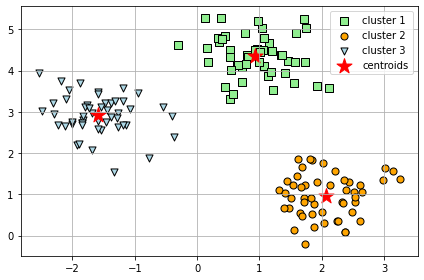

In [4]:
plt.scatter(X[y_km==0,0], 
            X[y_km==0,1], 
            s=50, 
            c='lightgreen', 
            marker='s',
            edgecolor='black',
            label='cluster 1')
plt.scatter(X[y_km==1,0], 
            X[y_km==1,1], 
            s=50, 
            c='orange', 
            marker='o', 
            edgecolor='black',
            label='cluster 2')
plt.scatter(X[y_km==2,0], 
            X[y_km==2,1], 
            s=50, 
            c='lightblue', 
            marker='v',
            edgecolor='black',
            label='cluster 3')
plt.scatter(km.cluster_centers_[:,0], 
            km.cluster_centers_[:,1], 
            s=250, 
            marker='*', 
            c='red', 
            label='centroids')
plt.legend()
plt.grid()
plt.tight_layout()
#plt.savefig('./figures/centroids.png', dpi=300)
plt.show()

<br>

### Using the elbow method to find the optimal number of clusters 

[[back to top](#Sections)]

In [5]:
print('Distortion: %.2f' % km.inertia_)

Distortion: 72.48


C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


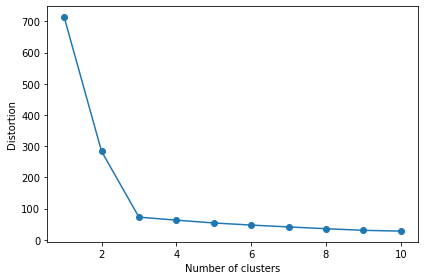

In [6]:
distortions = []
for i in range(1, 11):
    km = KMeans(n_clusters=i, 
                init='k-means++', 
                n_init=10, 
                max_iter=300, 
                random_state=0)
    km.fit(X)
    distortions .append(km.inertia_)
plt.plot(range(1,11), distortions , marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.tight_layout()
#plt.savefig('./figures/elbow.png', dpi=300)
plt.show()

<br>

### Quantifying the quality of clustering  via silhouette plots

[[back to top](#Sections)]

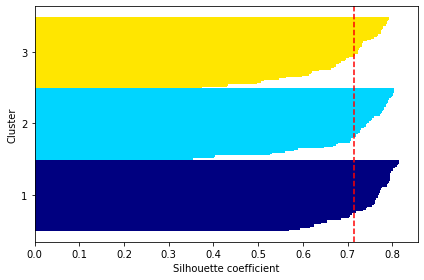

In [7]:
import numpy as np
from matplotlib import cm
from sklearn.metrics import silhouette_samples

km = KMeans(n_clusters=3, 
            init='k-means++', 
            n_init=10, 
            max_iter=300,
            tol=1e-04,
            random_state=0)
y_km = km.fit_predict(X)

cluster_labels = np.unique(y_km)
n_clusters = cluster_labels.shape[0]
silhouette_vals = silhouette_samples(X, y_km, metric='euclidean')
y_ax_lower, y_ax_upper = 0, 0
yticks = []
for i, c in enumerate(cluster_labels):
    c_silhouette_vals = silhouette_vals[y_km == c]
    c_silhouette_vals.sort()
    y_ax_upper += len(c_silhouette_vals)
    color = cm.jet(i / n_clusters)
    plt.barh(range(y_ax_lower, y_ax_upper), c_silhouette_vals, height=1.0, 
            edgecolor='none', color=color)

    yticks.append((y_ax_lower + y_ax_upper) / 2)
    y_ax_lower += len(c_silhouette_vals)
    
silhouette_avg = np.mean(silhouette_vals)
plt.axvline(silhouette_avg, color="red", linestyle="--") 

plt.yticks(yticks, cluster_labels + 1)
plt.ylabel('Cluster')
plt.xlabel('Silhouette coefficient')

plt.tight_layout()
# plt.savefig('./figures/silhouette.png', dpi=300)
plt.show()

Comparison to "bad" clustering:

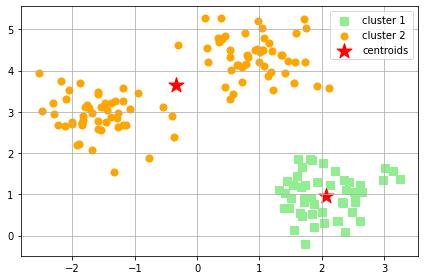

In [8]:
km = KMeans(n_clusters=2, 
            init='k-means++', 
            n_init=10, 
            max_iter=300,
            tol=1e-04,
            random_state=0)
y_km = km.fit_predict(X)

plt.scatter(X[y_km==0,0], 
            X[y_km==0,1], 
            s=50, 
            c='lightgreen', 
            marker='s', 
            label='cluster 1')
plt.scatter(X[y_km==1,0], 
            X[y_km==1,1], 
            s=50, 
            c='orange', 
            marker='o', 
            label='cluster 2')

plt.scatter(km.cluster_centers_[:,0], km.cluster_centers_[:,1], s=250, marker='*', c='red', label='centroids')
plt.legend()
plt.grid()
plt.tight_layout()
#plt.savefig('./figures/centroids_bad.png', dpi=300)
plt.show()

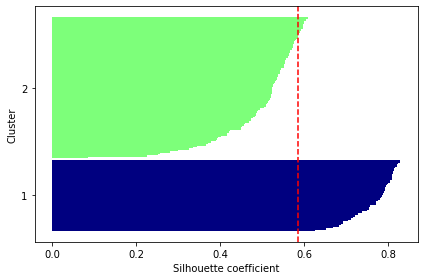

In [9]:
cluster_labels = np.unique(y_km)
n_clusters = cluster_labels.shape[0]
silhouette_vals = silhouette_samples(X, y_km, metric='euclidean')
y_ax_lower, y_ax_upper = 0, 0
yticks = []
for i, c in enumerate(cluster_labels):
    c_silhouette_vals = silhouette_vals[y_km == c]
    c_silhouette_vals.sort()
    y_ax_upper += len(c_silhouette_vals)
    color = cm.jet(i / n_clusters)
    plt.barh(range(y_ax_lower, y_ax_upper), c_silhouette_vals, height=1.0, 
            edgecolor='none', color=color)

    yticks.append((y_ax_lower + y_ax_upper) / 2)
    y_ax_lower += len(c_silhouette_vals)
    
silhouette_avg = np.mean(silhouette_vals)
plt.axvline(silhouette_avg, color="red", linestyle="--") 

plt.yticks(yticks, cluster_labels + 1)
plt.ylabel('Cluster')
plt.xlabel('Silhouette coefficient')

plt.tight_layout()
# plt.savefig('./figures/silhouette_bad.png', dpi=300)
plt.show()

<br>
<br>

# Organizing clusters as a hierarchical tree

[[back to top](#Sections)]

In [9]:
import pandas as pd
import numpy as np

np.random.seed(123)

variables = ['X', 'Y', 'Z']
labels = ['ID_0','ID_1','ID_2','ID_3','ID_4']

X = np.random.random_sample([5,3])*10
df = pd.DataFrame(X, columns=variables, index=labels)
df

,X,Y,Z
ID_0,6.964692,2.861393,2.268515
ID_1,5.513148,7.194690,4.231065
ID_2,9.807642,6.848297,4.809319
ID_3,3.921175,3.431780,7.290497
ID_4,4.385722,0.596779,3.980443


<br>

### Performing hierarchical clustering on a distance matrix

[[back to top](#Sections)]

In [10]:
from scipy.spatial.distance import pdist,squareform

row_dist = pd.DataFrame(squareform(pdist(df, metric='euclidean')), columns=labels, index=labels)
row_dist

,ID_0,ID_1,ID_2,ID_3,ID_4
ID_0,0.000000,4.973534,5.516653,5.899885,3.835396
ID_1,4.973534,0.000000,4.347073,5.104311,6.698233
ID_2,5.516653,4.347073,0.000000,7.244262,8.316594
ID_3,5.899885,5.104311,7.244262,0.000000,4.382864
ID_4,3.835396,6.698233,8.316594,4.382864,0.000000


We can either pass a condensed distance matrix (upper triangular) from the `pdist` function, or we can pass the "original" data array and define the `'euclidean'` metric as function argument n `linkage`. However, we should nott pass the squareform distance matrix, which would yield different distance values although the overall clustering could be the same.

In [11]:
# 1. incorrect approach: Squareform distance matrix

from scipy.cluster.hierarchy import linkage

row_clusters = linkage(row_dist, method='complete', metric='euclidean')
pd.DataFrame(row_clusters, 
             columns=['row label 1', 'row label 2', 'distance', 'no. of items in clust.'],
             index=['cluster %d' %(i+1) for i in range(row_clusters.shape[0])])

,row label 1,row label 2,distance,no. of items in clust.
cluster 1,0,4,6.521973,2
cluster 2,1,2,6.729603,2
cluster 3,3,5,8.539247,3
cluster 4,6,7,12.444824,5


In [12]:
# 2. correct approach: Condensed distance matrix

row_clusters = linkage(pdist(df, metric='euclidean'), method='complete')
pd.DataFrame(row_clusters, 
             columns=['row label 1', 'row label 2', 'distance', 'no. of items in clust.'],
             index=['cluster %d' %(i+1) for i in range(row_clusters.shape[0])])

,row label 1,row label 2,distance,no. of items in clust.
cluster 1,0,4,3.835396,2
cluster 2,1,2,4.347073,2
cluster 3,3,5,5.899885,3
cluster 4,6,7,8.316594,5


In [13]:
# 3. correct approach: Input sample matrix

row_clusters = linkage(df.values, method='complete', metric='euclidean')
pd.DataFrame(row_clusters, 
             columns=['row label 1', 'row label 2', 'distance', 'no. of items in clust.'],
             index=['cluster %d' %(i+1) for i in range(row_clusters.shape[0])])

,row label 1,row label 2,distance,no. of items in clust.
cluster 1,0,4,3.835396,2
cluster 2,1,2,4.347073,2
cluster 3,3,5,5.899885,3
cluster 4,6,7,8.316594,5


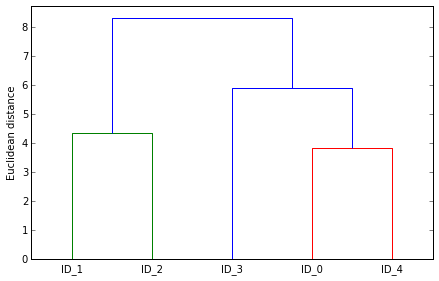

In [14]:
from scipy.cluster.hierarchy import dendrogram

# make dendrogram black (part 1/2)
# from scipy.cluster.hierarchy import set_link_color_palette
# set_link_color_palette(['black'])

row_dendr = dendrogram(row_clusters, 
                       labels=labels,
                       # make dendrogram black (part 2/2)
                       # color_threshold=np.inf
                       )
plt.tight_layout()
plt.ylabel('Euclidean distance')
#plt.savefig('./figures/dendrogram.png', dpi=300, 
#            bbox_inches='tight')
plt.show()

<br>

### Attaching dendrograms to a heat map

[[back to top](#Sections)]

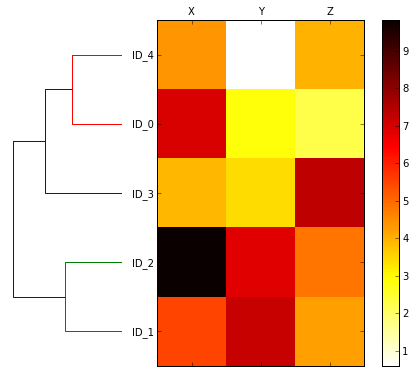

In [15]:
# plot row dendrogram
fig = plt.figure(figsize=(8,8))
axd = fig.add_axes([0.09,0.1,0.2,0.6])
row_dendr = dendrogram(row_clusters, orientation='right')

# reorder data with respect to clustering
df_rowclust = df.ix[row_dendr['leaves'][::-1]]

axd.set_xticks([])
axd.set_yticks([])

# remove axes spines from dendrogram
for i in axd.spines.values():
        i.set_visible(False)


        
# plot heatmap
axm = fig.add_axes([0.23,0.1,0.6,0.6]) # x-pos, y-pos, width, height
cax = axm.matshow(df_rowclust, interpolation='nearest', cmap='hot_r')
fig.colorbar(cax)
axm.set_xticklabels([''] + list(df_rowclust.columns))
axm.set_yticklabels([''] + list(df_rowclust.index))

# plt.savefig('./figures/heatmap.png', dpi=300)
plt.show()

<br>

### Applying agglomerative clustering via scikit-learn

[[back to top](#Sections)]

In [16]:
from sklearn.cluster import AgglomerativeClustering

ac = AgglomerativeClustering(n_clusters=2, affinity='euclidean', linkage='complete')
labels = ac.fit_predict(X)
print('Cluster labels: %s' % labels)

Cluster labels: [0 1 1 0 0]


<br>
<br>

# Locating regions of high density via DBSCAN

[[back to top](#Sections)]

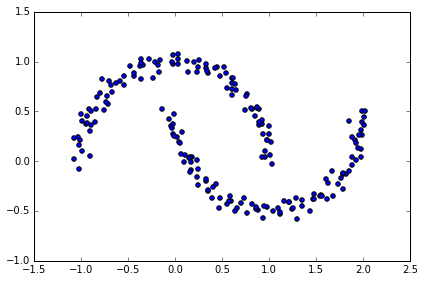

In [17]:
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=200, noise=0.05, random_state=0)
plt.scatter(X[:,0], X[:,1])
plt.tight_layout()
#plt.savefig('./figures/moons.png', dpi=300)
plt.show()

K-means and hierarchical clustering:

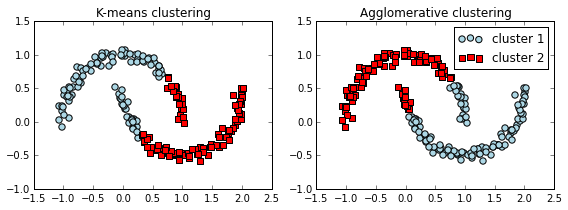

In [18]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,3))

km = KMeans(n_clusters=2, random_state=0)
y_km = km.fit_predict(X)
ax1.scatter(X[y_km==0,0], X[y_km==0,1], c='lightblue', marker='o', s=40, label='cluster 1')
ax1.scatter(X[y_km==1,0], X[y_km==1,1], c='red', marker='s', s=40, label='cluster 2')
ax1.set_title('K-means clustering')

ac = AgglomerativeClustering(n_clusters=2, affinity='euclidean', linkage='complete')
y_ac = ac.fit_predict(X)
ax2.scatter(X[y_ac==0,0], X[y_ac==0,1], c='lightblue', marker='o', s=40, label='cluster 1')
ax2.scatter(X[y_ac==1,0], X[y_ac==1,1], c='red', marker='s', s=40, label='cluster 2')
ax2.set_title('Agglomerative clustering')

plt.legend()
plt.tight_layout()
#plt.savefig('./figures/kmeans_and_ac.png', dpi=300)
plt.show()

Density-based clustering:

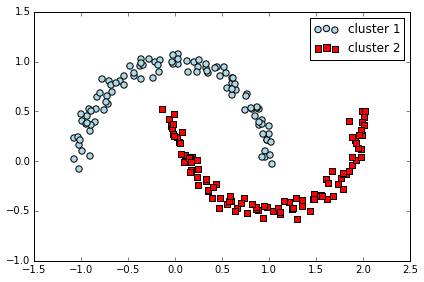

In [19]:
from sklearn.cluster import DBSCAN

db = DBSCAN(eps=0.2, min_samples=5, metric='euclidean')
y_db = db.fit_predict(X)
plt.scatter(X[y_db==0,0], X[y_db==0,1], c='lightblue', marker='o', s=40, label='cluster 1')
plt.scatter(X[y_db==1,0], X[y_db==1,1], c='red', marker='s', s=40, label='cluster 2')
plt.legend()
plt.tight_layout()
#plt.savefig('./figures/moons_dbscan.png', dpi=300)
plt.show()